In [1]:
%cd /notebooks/benchmark

/notebooks/benchmark


/usr/local/lib/python3.11/dist-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
from quantized_matrix import QuantizedMatrix

In [4]:
import numpy as np
from typing import List
import math
import torch

def permute_matrix_operation(a: torch.Tensor, permutations: torch.Tensor, matrices: List[torch.Tensor]):
    assert len(a.shape) in [2,3]
    n = a.shape[0] if len(a.shape) == 2 else a.shape[1]
    assert all(set(permutation.tolist()) == set(range(n)) for permutation in permutations)
    
    a_shape = a.shape

    if len(a.shape) == 2:
        a = a.unsqueeze(0)
    
    for permutation, matrix in zip(permutations, matrices):
        new_a = torch.zeros_like(a)
        group_size = matrix.shape[-1]
        num_groups = n // group_size
        grouped_a = a.reshape((a.shape[0], num_groups, group_size, a.shape[-1]))
        new_a = torch.einsum('gik,bgkj->bgij', matrix, grouped_a).reshape(a.shape)  
        a = new_a[:, permutation, :].clone()

    return a.reshape(a_shape)

In [21]:
import torch


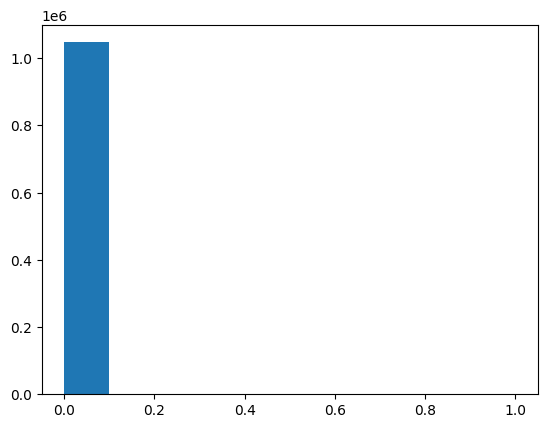

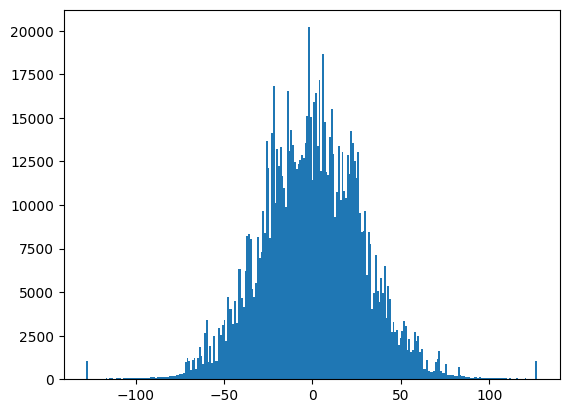

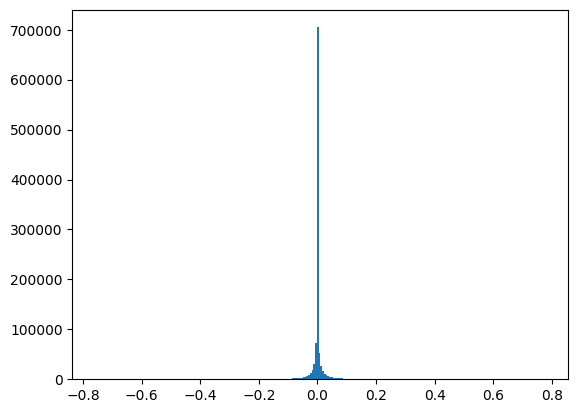

In [41]:
from quantized_matrix import QuantizedMatrix
import torch
from utils import *
from scipy.stats import ortho_group

mat = torch.eye(1024).cuda().to(torch.float32)
factors = prime_factors(1024)
rounds = len(factors)
permutations = torch.stack([torch.randperm(1024) for _ in range(rounds)]).cuda()
matrices = [torch.from_numpy(ortho_group.rvs(size=1024 // factor, dim=factor)).to('cuda', torch.float32) for factor in factors]
inverse_matrices_mT = [invert_matrices(matrix).mT.to('cuda') for matrix in matrices]   
permuted_weight = permute_matrix_operation(mat.mT, permutations, inverse_matrices_mT).mT
min_range = -128
max_range = 127
qw = QuantizedMatrix(permuted_weight, min_range, max_range)

import matplotlib.pyplot as plt

plt.figure()
plt.hist(mat.detach().cpu().numpy().ravel())
plt.show()

plt.figure()
plt.hist(qw.q.detach().cpu().numpy().ravel(), bins=256)
plt.show()


plt.figure()
plt.hist(permuted_weight.detach().cpu().numpy().ravel(), bins=256)
plt.show()



In [37]:
permuted_weight.ravel().std() * np.sqrt(1024)

tensor(1.0000, device='cuda:0')

In [38]:
mat.ravel().std() * np.sqrt(1024)

tensor(0.9995, device='cuda:0')

In [42]:
permuted_weight.ravel().max()

tensor(0.7796, device='cuda:0')

In [44]:
np.log(permuted_weight.ravel().max().cpu() / permuted_weight.ravel().std().cpu())

tensor(3.2167)

In [67]:
import torch
import torch.nn as nn
from consts import MIN_RANGE, MAX_RANGE
from utils import plot_error
import math
from fast_hadamard_transform import hadamard_transform
import torch.nn.functional as F
from scipy.stats import ortho_group

class QuantizedPermutationLinear(nn.Module):
    def __init__(self, input_linear, min_range=MIN_RANGE, max_range=MAX_RANGE, show_plot=False):
        super(QuantizedPermutationLinear, self).__init__()
        self.in_features = input_linear.in_features
        self.out_features = input_linear.out_features
        self.min_range = min_range
        self.max_range = max_range
        self.weight = nn.Parameter(input_linear.weight.clone())
        
        self.factors = prime_factors(self.in_features)
        self.rounds = len(self.factors)
        self.permutations = torch.stack([torch.randperm(self.in_features) for _ in range(self.rounds)]).to(device)
        self.matrices = [torch.from_numpy(ortho_group.rvs(size=self.in_features // factor, dim=factor)).to(device, torch.float32) for factor in self.factors]
        self.inverse_matrices_mT = [invert_matrices(matrix).mT.to(device) for matrix in self.matrices]   
        self.permuted_weight = permute_matrix_operation(self.weight.data.mT, self.permutations, self.inverse_matrices_mT).mT

        self.qw = QuantizedMatrix(self.permuted_weight, self.min_range, self.max_range)
        
        self.show_plot = show_plot
        
        if self.show_plot:
            plot_error(self.qw.dequantize(), self.permuted_weight, title='Quantization error for weights of linear layer')

        if input_linear.bias is not None:
            self.bias = nn.Parameter(input_linear.bias.clone())
        else:
            self.bias = None


    def forward(self, x):
        dim_two = False
        if len(x.shape) == 2:
            x = x.unsqueeze(0)
            dim_two = True

        permuted_x = permute_matrix_operation(x.mT, self.permutations, self.matrices).mT
        qx = QuantizedMatrix(permuted_x, self.min_range, self.max_range)

        if self.show_plot:
            fig, axes = plt.subplots(1,2)
            axes[0].hist(x.ravel().cpu().numpy(), bins=255)
            axes[0].set_title('unquantized input')        
            axes[1].hist(qx.q.ravel().cpu().numpy(), bins=255)
            axes[1].set_title('quantized input')
            plt.show()
            
        res = qx @ self.qw + self.bias if self.bias is not None else qx @ self.qw

        if dim_two:
            res = res.squeeze(0)
        return res

    def __repr__(self):
        return f"QuantizedHadamardLinear(in_features={self.in_features}, out_features={self.out_features})"

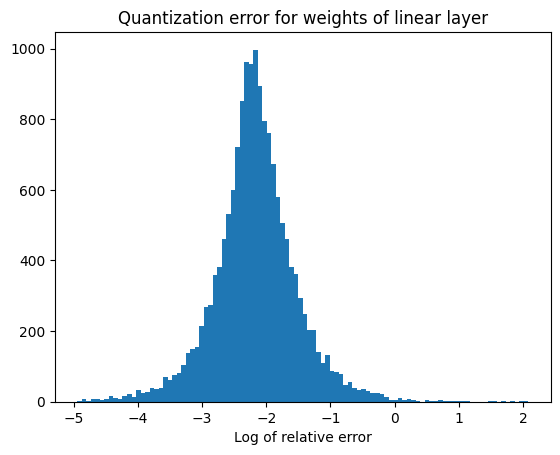

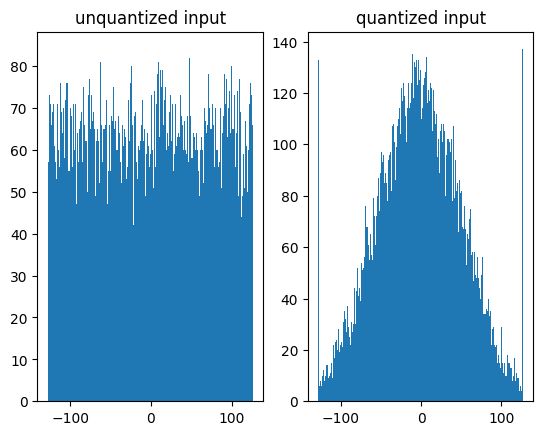

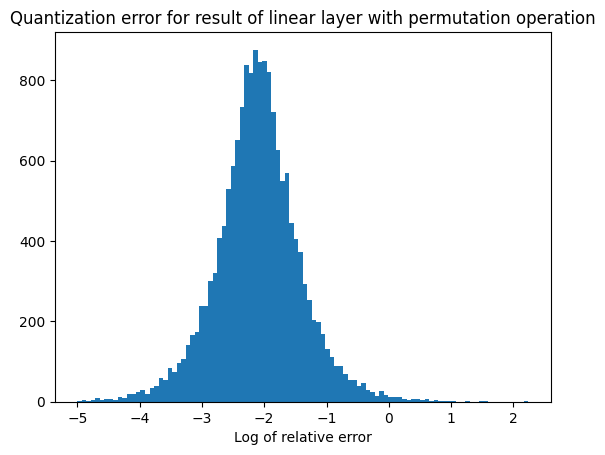

In [68]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

linear_layer = nn.Linear(128, 128, bias=False).to(device)
quantized_linear_layer = QuantizedPermutationLinear(linear_layer, show_plot=True, min_range=-128, max_range=127)
v = torch.randint(-128,127,size=(1,128,128)).to(device, dtype=torch.float32)
plot_error(quantized_linear_layer(v), linear_layer(v), title="Quantization error for result of linear layer with permutation operation")

In [10]:
a = permute_matrix_operation(v.mT, quantized_linear_layer.permutations, quantized_linear_layer.matrices).mT
b = quantized_linear_layer.permuted_weight

In [26]:
dataset

NameError: name 'dataset' is not defined

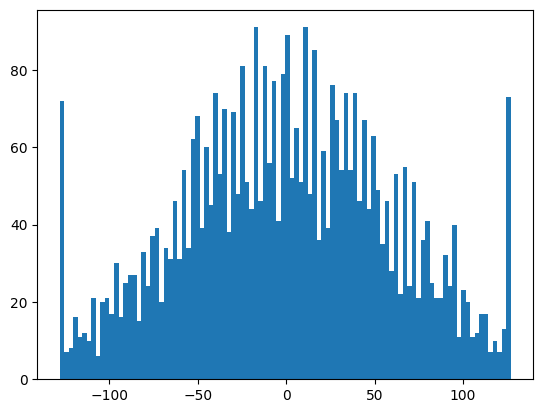

In [15]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist(quantized_linear_layer.qw.q.ravel().cpu().numpy(), bins=100)
plt.show()

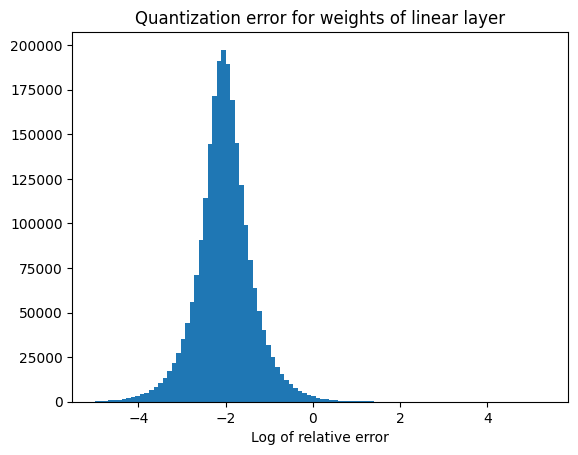

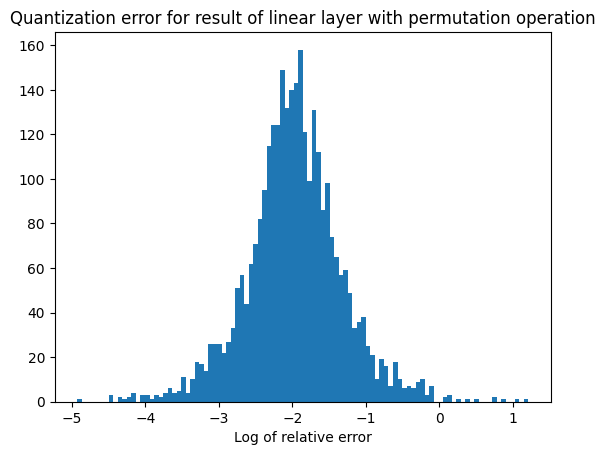

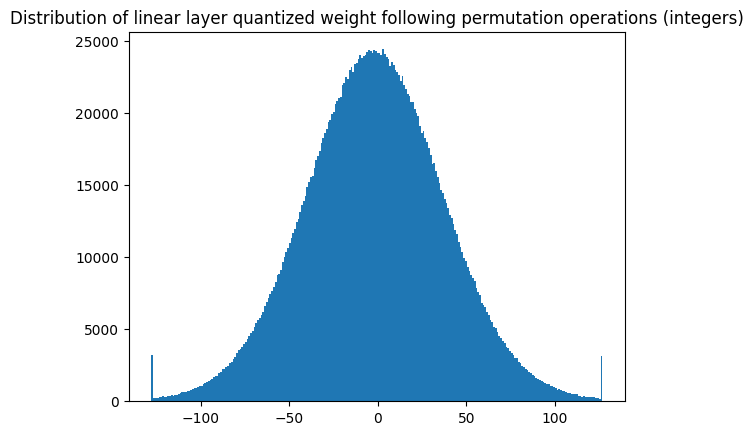

In [35]:
from torchvision import models

model = models.vit_b_16(weights='DEFAULT')
model.eval()
model.to(device)

mlp = model.encoder.layers[0].mlp
linear = mlp[0]
quantized_linear = QuantizedPermutationLinear(linear, show_plot=True)
v = torch.randn(1, 1, 768).cuda()

plot_error(quantized_linear(v), linear(v), title="Quantization error for result of linear layer with permutation operation")

plt.figure()
plt.title('Distribution of linear layer quantized weight following permutation operations (integers)')
plt.hist(quantized_linear.qw.q.ravel().cpu().numpy(), bins=256)
plt.show()

In [65]:
dir(linear)

['T_destination',
 '__annotations__',
 '__call__',
 '__class__',
 '__constants__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_apply',
 '_backward_hooks',
 '_backward_pre_hooks',
 '_buffers',
 '_call_impl',
 '_compiled_call_impl',
 '_forward_hooks',
 '_forward_hooks_always_called',
 '_forward_hooks_with_kwargs',
 '_forward_pre_hooks',
 '_forward_pre_hooks_with_kwargs',
 '_get_backward_hooks',
 '_get_backward_pre_hooks',
 '_get_name',
 '_is_full_backward_hook',
 '_load_from_state_dict',
 '_load_state_dict_post_hooks',
 '_load_state_dict_pre_hooks',
 '_maybe_warn_non_full_backward_hook',
 '_modules',
 '_named_members',
 '_non_per

In [27]:
from pathlib import Path
from utils import compute_accuracy, test_model
from imagenet.dataset import ImagenetDataset


dataset = ImagenetDataset(root='imagenet/imagenet_subtrain', transform=models.ViT_B_16_Weights.IMAGENET1K_V1.transforms())
test_model(dataset, model, 512, 32)

  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy on the sample batch: 93.95%


0.939453125

In [29]:
from torch.utils.data import DataLoader
data_loader = DataLoader(dataset)

torch.Size([1, 3, 224, 224])


AssertionError: 

In [41]:
import copy

def create_quantized_model(module, min_range=MIN_RANGE, max_range=MAX_RANGE):
    module_copy = copy.deepcopy(module)

    def replace_linear_with_quantized_linear(submodule):
        for name, layer in submodule.named_children():
            if isinstance(layer, nn.Linear):
                setattr(submodule, name, QuantizedPermutationLinear(layer, min_range=min_range, max_range=max_range))
            else:
                replace_linear_with_quantized_linear(layer)

    replace_linear_with_quantized_linear(module_copy)

    return module_copy

In [55]:
quantized_model = create_quantized_model(model, min_range=-4, max_range=3)
test_model(dataset, quantized_model, 512, 32)

  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy on the sample batch: 87.11%


0.87109375

In [56]:
quantized_model

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): QuantizedHadamardLinear(in_features=768, out_features=768)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): QuantizedHadamardLinear(in_features=768, out_features=3072)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): QuantizedHadamardLinear(in_features=3072, out_features=768)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attentio

In [70]:
from tqdm.auto import tqdm

accuracies = []
ranges = [(-i, i-1) for i in range(8, 128+1, 8)]
# ranges = [(-128, i-1) for i in range(-128+16, 128+1, 16)]
for r in tqdm(ranges):
    quantized_model = create_quantized_model(model, min_range=r[0], max_range=r[1])
    accuracy = test_model(dataset, quantized_model, 512, 32)
    accuracies.append(accuracy)

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy on the sample batch: 92.58%


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy on the sample batch: 93.95%


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy on the sample batch: 94.14%


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy on the sample batch: 94.14%


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy on the sample batch: 93.95%


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy on the sample batch: 94.14%


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy on the sample batch: 93.95%


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy on the sample batch: 93.95%


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy on the sample batch: 94.14%


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy on the sample batch: 93.95%


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy on the sample batch: 93.95%


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy on the sample batch: 93.95%


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy on the sample batch: 93.95%


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy on the sample batch: 93.95%


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy on the sample batch: 93.95%


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy on the sample batch: 93.95%


In [73]:
print(f"{ranges=}\n{accuracies=}")

ranges=[(-8, 7), (-16, 15), (-24, 23), (-32, 31), (-40, 39), (-48, 47), (-56, 55), (-64, 63), (-72, 71), (-80, 79), (-88, 87), (-96, 95), (-104, 103), (-112, 111), (-120, 119), (-128, 127)]
accuracies=[0.92578125, 0.939453125, 0.94140625, 0.94140625, 0.939453125, 0.94140625, 0.939453125, 0.939453125, 0.94140625, 0.939453125, 0.939453125, 0.939453125, 0.939453125, 0.939453125, 0.939453125, 0.939453125]


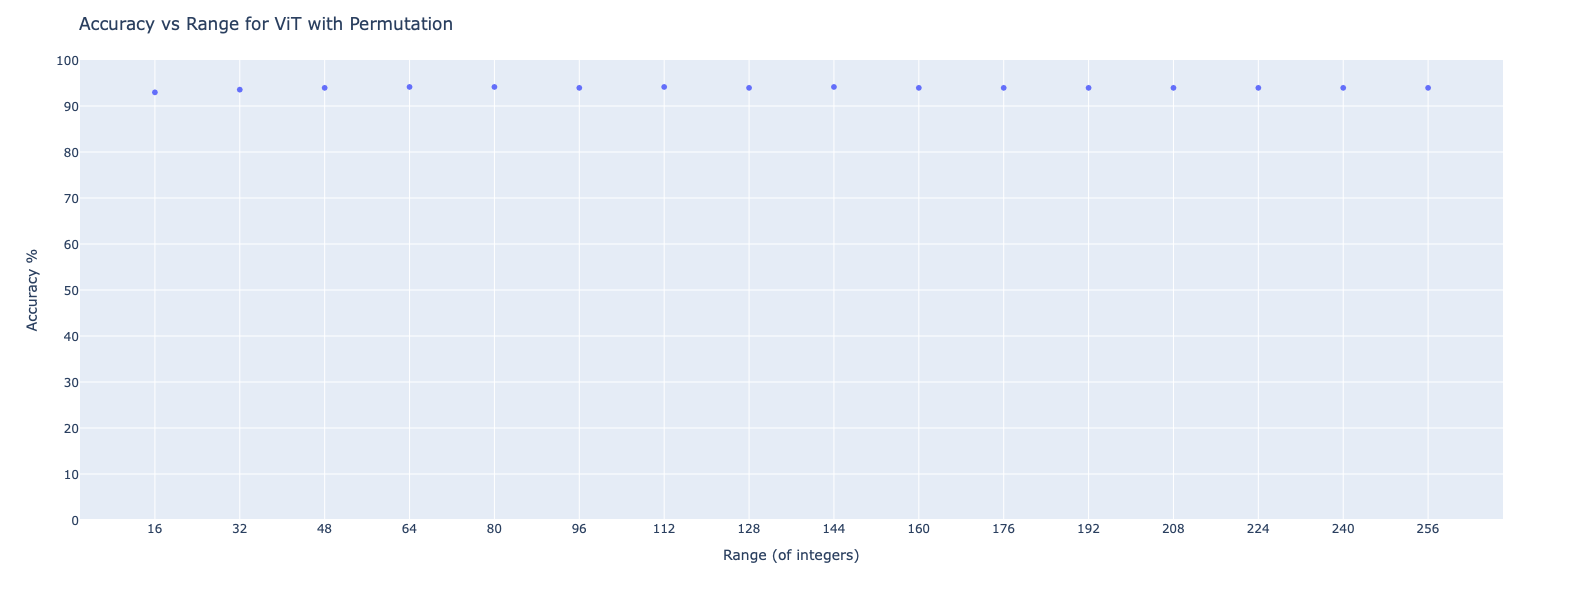

In [61]:
import plotly.express as px

x = [r[1] - r[0] + 1 for r in ranges]
fig = px.scatter(x=x, y=np.array(accuracies) * 100, height=600)
fig.update_layout(
    title="Accuracy vs Range for ViT with Permutation",
    xaxis_title="Range (of integers)",
    xaxis=dict(
        title_text="Range (of integers)",
        tickvals=x,
        tickmode="array",
    ),
    yaxis=dict(
        title_text="Accuracy %",
        dtick=10,
        range=[0, 100],
    )
)
fig.show()


In [69]:
quantized_model = create_quantized_model(model, min_range=-128, max_range=127)
accuracy = test_model(dataset, quantized_model, 512, 32)

  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy on the sample batch: 93.95%
